# Diplomado en Ciencia de Datos  
## Práctica Final: Convénceme con datos

**Nombre**: Zadkiel David Zerpa
<br> **Fecha:** 14 Feb, 2026


## Dataset
**Archivo:** `dataset_storytelling.xlsx`  
**Link:** `https://github.com/ZadkielZ/dataset_ejercicio1/raw/refs/heads/main/dataset_storytelling.xlsx`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_URL = "https://github.com/ZadkielZ/dataset_ejercicio1/raw/refs/heads/main/dataset_storytelling.xlsx"


df = pd.read_excel(DATA_URL)

display(df.head())
print("\n")
display(df.describe())

,Edad,Género,País,Ciudad,Curso inscrito,Tiempo de conexión semanal,Evaluación promedio,Finalización del curso,Interacciones en foros,Nivel educativo,Fecha de inscripción
0,56,Other,Mexico,Mexico City,Data Visualization,7.8,91.2,Yes,4,High School,2025-04-14
1,41,Other,Mexico,Monterrey,Statistics,12.1,86.0,Yes,3,Bachelor,2025-01-21
2,50,Male,Mexico,Mexico City,Machine Learning,11.0,77.3,Yes,4,High School,2025-06-24
3,61,Other,Colombia,Cali,Statistics,2.3,80.6,Yes,3,Bachelor,2025-06-16
4,35,Male,Argentina,Buenos Aires,Python Programming,7.6,63.9,Yes,4,High School,2025-03-22


,Edad,Tiempo de conexión semanal,Evaluación promedio,Interacciones en foros
count,1000.000000,1000.00000,1000.000000,1000.000000
mean,40.985000,10.16860,79.819200,4.924000
std,13.502929,3.95307,11.621269,2.173234
min,18.000000,0.00000,60.000000,0.000000
25%,30.000000,7.40000,69.300000,3.000000
50%,41.000000,10.50000,79.850000,5.000000
75%,52.000000,12.90000,89.700000,6.000000
max,64.000000,21.80000,99.900000,13.000000


## Identificación de patrones, anomalías y segmentos clave.

Aplicamos un modelo K-Modes categórico para buscar posibles patrones/anomalías

Cluster_cat
0    455
1    319
2    226
Name: count, dtype: int64


,Género,País,Ciudad,Curso inscrito,Nivel educativo
0,Female,Argentina,Rosario,Data Visualization,Bachelor
1,Male,Chile,Concepción,Machine Learning,Master
2,Other,Colombia,Cali,Data Science,Bachelor


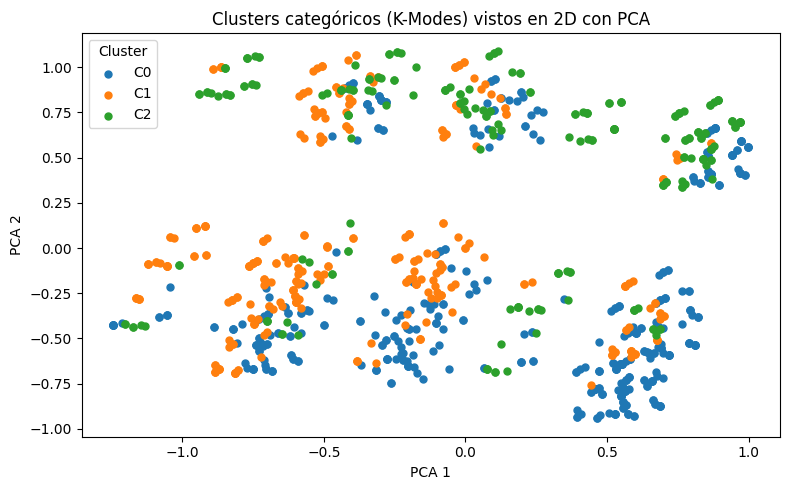

In [2]:
!pip -q install kmodes

from kmodes.kmodes import KModes
from sklearn.decomposition import PCA

# Elegimos variables categóricas para K-Modes
cat_cols = ["Género", "País", "Ciudad", "Curso inscrito", "Nivel educativo"]

X_cat = df[cat_cols].astype(str)

# Entrenar K-Modes -- modelo de juguete :)
k = 3
km = KModes(n_clusters=k, init="Huang", n_init=5, random_state=42)
df["Cluster_cat"] = km.fit_predict(X_cat)

# tamaños de cluster
print(df["Cluster_cat"].value_counts().sort_index())

# Centroides de cada cluster
centroids = pd.DataFrame(km.cluster_centroids_, columns=cat_cols)
display(centroids)

# Graficamos
X_onehot = pd.get_dummies(X_cat)
X_2d = PCA(n_components=2, random_state=42).fit_transform(X_onehot)

# Setup para mantener consistencia visual de orden, labels y colores
order = [0, 1, 2]
xlabels = {0: "C0", 1: "C1", 2: "C2"}
palette = plt.rcParams["axes.prop_cycle"].by_key()["color"]
cluster_color = {0: palette[0], 1: palette[1], 2: palette[2]}

plt.figure(figsize=(8, 5))

for c in order:
    mask = df["Cluster_cat"] == c
    plt.scatter(
        X_2d[mask, 0], X_2d[mask, 1],
        s=25,
        color=cluster_color[c],
        label=xlabels[c]
    )

plt.title("Clusters categóricos (K-Modes) vistos en 2D con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [3]:
# Tabla resumen: Top 3 categorías por variable dentro de cada cluster
rows = []

for c in sorted(df["Cluster_cat"].unique()):
    row = {"Cluster": c, "Tamaño": int((df["Cluster_cat"] == c).sum())}

    for col in cat_cols:
        top3 = df[df["Cluster_cat"] == c][col].value_counts().head(3)
        row[f"{col} (top3)"] = ", ".join([f"{idx} ({int(val)})" for idx, val in top3.items()])

    rows.append(row)

cluster_profile = pd.DataFrame(rows).set_index("Cluster")
display(cluster_profile)

,Tamaño,Género (top3),País (top3),Ciudad (top3),Curso inscrito (top3),Nivel educativo (top3)
Cluster,,,,,,
0,455,"Female (255), Other (109), Male (91)","Argentina (182), Peru (93), Mexico (92)","Rosario (76), Buenos Aires (61), Córdoba (45)","Data Visualization (167), Python Programming (...","Bachelor (245), Master (94), High School (80)"
1,319,"Male (182), Other (87), Female (50)","Chile (140), Mexico (66), Peru (56)","Concepción (60), Valparaíso (42), Santiago (38)","Machine Learning (116), Python Programming (69...","Master (179), High School (66), Bachelor (48)"
2,226,"Other (170), Male (34), Female (22)","Colombia (116), Peru (50), Mexico (40)","Cali (51), Bogotá (34), Medellín (31)","Data Science (76), Statistics (57), Python Pro...","Bachelor (117), High School (49), Master (39)"


In [4]:
num_cols = ["Tiempo de conexión semanal", "Evaluación promedio", "Interacciones en foros", "Edad"]
display(df.groupby("Cluster_cat")[num_cols].mean())
tasa_fin = df.groupby("Cluster_cat")["Finalización del curso"].apply(lambda s: (s=="Yes").mean())
display(tasa_fin)

,Tiempo de conexión semanal,Evaluación promedio,Interacciones en foros,Edad
Cluster_cat,,,,
0,10.317143,80.698462,4.868132,41.096703
1,9.789655,79.834483,4.987461,40.645768
2,10.404425,78.027434,4.946903,41.238938


,Finalización del curso
Cluster_cat,
0,0.683516
1,0.670846
2,0.712389


## Identificaciones de problemáticas y oportunidades concretas

* **Cluster 0**: tiene mejor evaluación (80.7%) y buena tasa de finalización (68.4%). <br>
experiencia más satisfactoria pero aún hay margen de mejora en finalización.


* **Cluster 1**: tiene la peor finalización (67.1%) y también el menor tiempo de conexión (9.8 hrs). <br> señal de desenganche: se conectan menos y terminan menos.

* **Cluster 2**: tiene la mejor tasa de finalización (71.2%) pero su evaluación promedio es la más baja: 78 <br> terminan más, pero les gusta menos o el curso es más difícil.


## Construcción de narrativa con 3 visualizaciones claves

In [5]:
# Etiquetas para que cada cluster “se entienda” en los gráficos
cluster_labels = {
    0: "C0: AR/PE/MX · Female · Bachelor · (DataViz/Python/Stats)",
    1: "C1: CL · Male · Master · (ML/Python/Stats)",
    2: "C2: CO · Other · Bachelor · (DS/Stats/Python)"
}

df["Cluster_label"] = df["Cluster_cat"].map(cluster_labels)

order = [0, 1, 2]
labels_ordered = [cluster_labels[c] for c in order]

In [6]:
# Resumen por cluster (para usarlo en los 3 gráficos)
summary = df.groupby("Cluster_cat").agg(
    n=("Cluster_cat", "size"),
    finalizacion=("Finalización del curso", lambda s: (s == "Yes").mean()),
    evaluacion=("Evaluación promedio", "mean"),
    conexion=("Tiempo de conexión semanal", "mean")
).reset_index()

overall_fin = (df["Finalización del curso"] == "Yes").mean()
overall_eval = df["Evaluación promedio"].mean()

display(summary)

,Cluster_cat,n,finalizacion,evaluacion,conexion
0,0,455,0.683516,80.698462,10.317143
1,1,319,0.670846,79.834483,9.789655
2,2,226,0.712389,78.027434,10.404425


In [7]:
# Setup para mantener consistencia visual de orden, labels y colores
order = [0, 1, 2]
xlabels = {0: "C0", 1: "C1", 2: "C2"}
palette = plt.rcParams["axes.prop_cycle"].by_key()["color"]
cluster_color = {0: palette[0], 1: palette[1], 2: palette[2]}

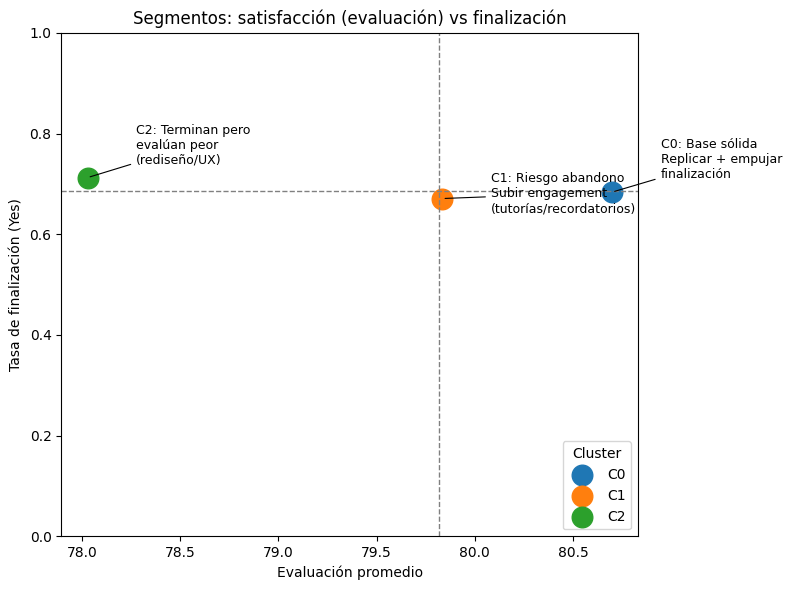

In [8]:
# Gráfico de coordenadas
plt.figure(figsize=(8, 6))

for c in order:
    row = summary[summary["Cluster_cat"] == c].iloc[0]
    plt.scatter(row["evaluacion"], row["finalizacion"], s=220, color=cluster_color[c], label=xlabels[c])

plt.axhline(overall_fin, linestyle="--", linewidth=1, color="gray")
plt.axvline(overall_eval, linestyle="--", linewidth=1, color="gray")

acciones = {
    0: "Base sólida\nReplicar + empujar\nfinalización",
    1: "Riesgo abandono\nSubir engagement\n(tutorías/recordatorios)",
    2: "Terminan pero\nevalúan peor\n(rediseño/UX)"
}

offsets = {
    0: (35, 10),
    1: (35, -10),
    2: (35, 10),
}

for c in order:
    row = summary[summary["Cluster_cat"] == c].iloc[0]
    dx, dy = offsets[c]
    plt.annotate(
        f"{xlabels[c]}: {acciones[c]}",
        xy=(row["evaluacion"], row["finalizacion"]),
        xytext=(dx, dy),
        textcoords="offset points",
        fontsize=9,
        arrowprops=dict(arrowstyle="-", linewidth=0.8)
    )

plt.title("Segmentos: satisfacción (evaluación) vs finalización")
plt.xlabel("Evaluación promedio")
plt.ylabel("Tasa de finalización (Yes)")
plt.ylim(0, 1)

plt.legend(title="Cluster", loc="lower right")
plt.tight_layout()
plt.show()

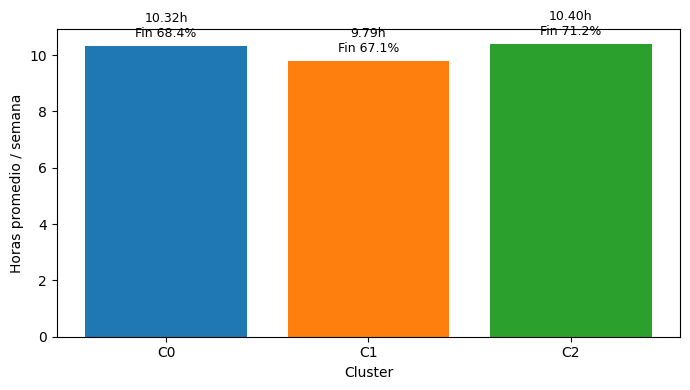

In [9]:
# Engagement por segmento: tiempo de conexión semanal

summary_plot = summary.set_index("Cluster_cat").reindex(order)

plt.figure(figsize=(7, 4))
bars = plt.bar([xlabels[c] for c in order],
               summary_plot["conexion"].values,
               color=[cluster_color[c] for c in order])

ymax = max(summary_plot["conexion"].values)
for i, c in enumerate(order):
    conn = summary_plot.loc[c, "conexion"]
    fin = summary_plot.loc[c, "finalizacion"]
    plt.text(i, conn + (ymax * 0.03), f"{conn:.2f}h\nFin {fin:.1%}", ha="center", fontsize=9)

plt.xlabel("Cluster")
plt.ylabel("Horas promedio / semana")
plt.tight_layout()
plt.show()

/tmp/ipython-input-1539370289.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=[xlabels[c] for c in order])


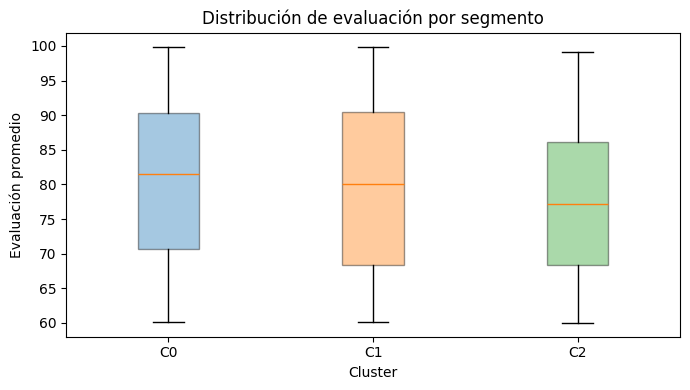

In [10]:
# Distribuci[on de promedios de evauación por cluster
data = [df[df["Cluster_cat"] == c]["Evaluación promedio"].dropna().values for c in order]
fig, ax = plt.subplots(figsize=(7, 4))
bp = ax.boxplot(data, patch_artist=True, labels=[xlabels[c] for c in order])

for patch, c in zip(bp["boxes"], order):
    patch.set_facecolor(cluster_color[c])
    patch.set_alpha(0.4)

ax.grid(False)

ax.set_title("Distribución de evaluación por segmento")
ax.set_xlabel("Cluster")
ax.set_ylabel("Evaluación promedio")

plt.tight_layout()
plt.show()

## Recomendaciones alineadas por cluster

#### **Cluster 0 - Sólidos, satisfechos, pero no todos terminan**

**Perfil:** Predomina *Female* | principalmente *Argentina/Perú/México* | cursos top: **Data Visualization / Python / Statistics** | nivel educativo dominante: **Bachelor**. <br>
**Dato clave:** Mejor evaluación (**80.7**) pero finalización “media” (**68.4%**).

* **Optimizar o empujar a finalización:** agregar **checkpoints** (50% / 75%), o **resumen de lo visto** al final de cada módulo y recordatorios (email/in-app) a quienes se atrasan.
* **Tutorías opcionales y enfocadas (no masivas):** sesiones cortas tipo “office hours” para dudas puntuales (Python/Stats/DataViz) más platicar sobre las preguntas frecuenas por tema.
* **Mejorar continuidad:** promover tanto para los tutores como a los estudiantes recapitular lo visto y ver oportunidades de mejora.


#### **Cluster 1 - Riesgo de abandono por bajo engagement**

**Perfil:** Predomina *Male* | principalmente *Chile* | cursos top: **Machine Learning / Python / Statistics** | nivel educativo dominante: **Master**. <br>
**Dato clave:** Menor conexión (**9.79 hrs**) y peor finalización (**67.1%**).

* **Integracón y ruta clara en cursos difíciles (ML):** mapa del curso aunado a expectativas de tiempo a aplicar por semana e incentivar logros semanales (una prácticas fáciles para enganchar).
* **Acompañamiento activo (tutorías/mentoría ligera):** sesiones semanales cortas de resolución de ejercicios, y avisos (email/sms) automático si no se conectan en 1 semana (esto ataca directamente la baja conexión).

#### **Cluster 2 - Terminan, pero la experiencia es peor**

**Perfil:** Predomina *Other*| principalmente *Colombia*| cursos top: **Data Science / Statistics / Python**| nivel educativo dominante: **Bachelor**. <br>
**Dato clave:** Mejor finalización (**71.2%**) pero peor evaluación (**78.0**) - (Usualmente cuando terminan pero con peor calificación, suele ser indicador de fricción/claridad).

* **Rediseño de calidad (claridad y soporte):** simplificar explicaciones, más ejemplos guiados, y “pasos tipo receta” en ejercicios para subir satisfacción sin bajar exigencia.
* **Detección de fricción con encuesta rápida:** 2–3 preguntas al terminar cada módulo (“¿qué fue confuso?”, “¿qué faltó?”, etc).
* **Mejor UX de aprendizaje:** mejorar navegación, resúmenes por lección, y glosario.

## Audiencia Objetivo

Coordinación académica y responsables de experiencia del estudiante

## Refelxión Final

El storytelling es una herramienta extremadamente poderosa. Como dice la frase de Spiderman: “un gran poder conlleva una gran responsabilidad”. Cuando trabajamos con datos+storytelling, esa frase aplica perfectamente.

Un buen storytelling puede convertir información compleja en algo claro y convincente para los stakeholders, facilitando decisiones estratégicas. Pero esa misma fuerza también puede jugar en contra si se utiliza de manera poco ética. Es posible presentar datos de forma sesgada, seleccionar solo lo que conviene o exagerar hallazgos para “vender” una narrativa. Por eso, al construir historias con datos, la honestidad y la responsabilidad profesional son fundamentales. Un uso inadecuado no solo puede impactar negativamente a la empresa, sino también a los usuarios/consumidores.

##